In [4]:
import pandas as pd

df = pd.read_csv('../data/raw/manual pattern annotations.csv', index_col=0)
print(df.columns)
df.columns = [col.strip() for col in df.columns]
df = df.rename({
    'Participant': 'pid',
    'Task': 'tid',
    'Code snippet': 'snippet',
    'Correntness': 'correctness',
    'Level of investment': 'investment',
    'Vertical Selection Strategy': 'selection_strategy',
    'Rough Direction': 'direction',
    'Time': 'time',
    'Start': 'start_time',
    'Stop': 'end_time',
    'Code Interaction': 'code_interaction',
    
},
          axis=1)

#df['correctness'] = df['correctness'] > 0
print(df.columns)
# 

Index(['Order per task', 'Code snippet', 'Participant', 'Task',
       'Participant/Task', 'Task Duration', 'Understand', 'Correntness',
       'Level of investment', 'Direction', 'Rough Direction',
       'Code Interaction', 'Vertical Selection Strategy',
       'Horizontal Selection Strategy', 'Time', 'Start', 'Stop',
       'Block Duration', '%(Block Duration)', 'Intent', 'Intent (updated)',
       'Lines', 'Confidence', 'Comment for manual analysis', 'Random Set #'],
      dtype='object')
Index(['Order per task', 'snippet', 'pid', 'tid', 'Participant/Task',
       'Task Duration', 'Understand', 'correctness', 'investment', 'Direction',
       'direction', 'code_interaction', 'selection_strategy',
       'Horizontal Selection Strategy', 'time', 'start_time', 'end_time',
       'Block Duration', '%(Block Duration)', 'Intent', 'Intent (updated)',
       'Lines', 'Confidence', 'Comment for manual analysis', 'Random Set #'],
      dtype='object')


In [8]:
df = df[[
    'snippet', 'pid', 'tid', 'correctness', 'investment', 'selection_strategy',
    'direction', 'code_interaction', 'start_time', 'end_time'
]].copy()

"""
print(df['investment'].unique())
print(df['selection_strategy'].unique())
print(df['direction'].unique())
print(df['code_interaction'].unique())

replacements = {
    'back and forth, generally forward': 'forward',
    'back and forth, generally backward': 'backward',
}
df = df.assign(direction=df['direction'].apply(lambda x: replacements.get(x, x)))
"""
# Replace invalid annotations
valid_pattern_values = {
    "investment": ['Medium' 'Quick' 'Indepth'],
    "selection_strategy": ['No strategy' 'Dynamic' 'Linear'],
    "direction": ['Backward' 'No direction' 'Forward' 'Back and forth'
                  'Reverse the order of definition' 'In the order of definition'
                  'Back and forth the order of denifition'],
    "code_interaction": ['Intra procedure' 'Inter procedure'],
}
for col, valid_values in valid_pattern_values.items():
    df = df.loc[df[col].isin(valid_values)]


# df['pattern'] = list(
#     map(
#         tuple,
#         zip(*(df[col]
#             for col in ['investment', 'selection_strategy', 'direction']))))

df['duration'] = df['end_time'] - df['start_time']
df['pid'] = 'p' + df['pid'].astype(str)
df['tid'] = 't' + df['tid'].astype(str)

In [10]:
# df.to_parquet("../data/processed/manual_pattern_annotations.parq")
df.astype({
    'snippet': 'category',
    'investment': 'category',
    'selection_strategy': 'category',
    'direction': 'category',
    # 'pattern': 'category'
}).set_index(['pid', 'tid']).to_parquet("../data/processed/manual_pattern_annotations.parq")
# df.dtypes


In [13]:
df['pattern'] = [
    (a, b, c, d)
    for a, b, c in zip(df['investment'], df['direction'], df['selection_strategy'], df['code_interaction'])
] 

In [15]:

import functools
import numpy as np
import seaborn as sns
def find_most_frequent(df, k=0):
    counts = df.value_counts()
    return counts[k] if len(counts) - 1 >= k else np.nan


freqs = df.groupby(['pid', 'tid'])['pattern'].agg(find_most_frequent).reset_index(name='top1')
freqs['top2'] = df.groupby(['pid', 'tid'])['pattern'].agg(functools.partial(find_most_frequent, k=1)).reset_index(name='top2')['top2']
freqs['delta'] = freqs['top1'] - freqs['top2']

x = pd.melt(freqs, id_vars=['pid', 'tid'], value_vars=['top1', 'top2'])

sns.displot(data=x, x='value', hue='variable', kind='kde')
# sns.displot(data=freqs, x='top1', kind='kde')
# sns.displot(data=freqs, x='top2', kind='kde')

In [16]:
sns.displot(data=freqs, x='delta', )

In [17]:
d = freqs.query('delta == 1.0').sort_values(by=['top1', 'top2'])

print(len(d))
d

0


,pid,tid,top1,top2,delta


In [18]:
def find_most_frequent_duration(df, k=0):
    if len(df) <= 1:
        return np.nan
    return df.iloc[0] - df.iloc[1]


duration_sums = df.groupby(['pid', 'tid',
                            'pattern'])['duration'].sum().reset_index()
#
freqs_duration = duration_sums.sort_values(
    by=['duration', 'pid', 'tid'], ascending=False).groupby(
        ['pid',
         'tid']).apply(lambda x: x.head(2)).reset_index(drop=True)

grouper = freqs_duration.groupby(['pid', 'tid'])

# sns.displot(data=freqs_duration, x='delta')
# duration_sums

def topk(k):
    def _inner(df):
        try:
            return df.iloc[k]
        except:
            return np.nan
    return _inner

freqs_duration = grouper['duration'].agg(find_most_frequent_duration).reset_index(name='delta')
freqs_duration['top1'] = grouper['duration'].agg(topk(0)).reset_index(name='top1')['top1']
freqs_duration['top2'] = grouper['duration'].agg(topk(1)).reset_index(name='top2')['top2']

freqs_duration

<ipython-input-18-fee48bcb2287>:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  'tid']).apply(lambda x: x.head(2)).reset_index(drop=True)


,pid,tid,delta,top1,top2


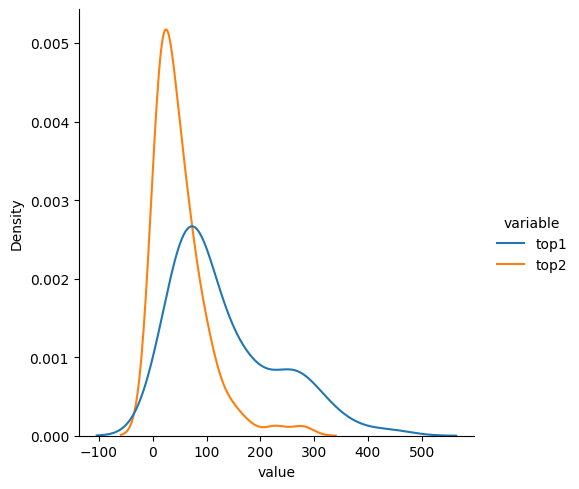

In [153]:
melted = pd.melt(freqs_duration, id_vars=['pid', 'tid'], value_vars=['top1', 'top2'])

melted

sns.displot(data=melted, x='value', hue='variable', kind='kde')

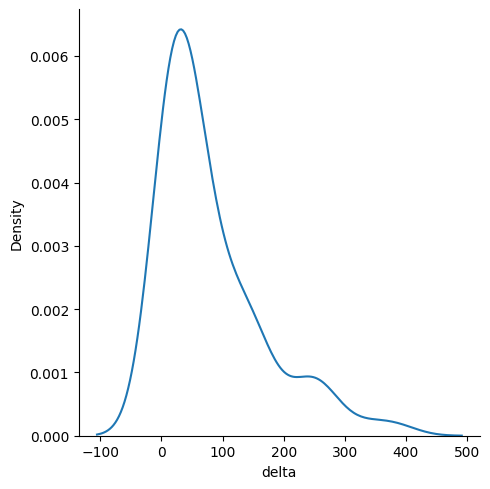

In [156]:
sns.displot(data=freqs_duration, x='delta', kind='kde')

In [165]:
freqs_duration['delta_pct'] = freqs_duration['delta'] / freqs_duration['top1']

freqs_duration.sort_values(by='delta_pct')['delta_pct'].describe()

count    80.000000
mean      0.556000
std       0.284571
min       0.010676
25%       0.293182
50%       0.621591
75%       0.833955
max       0.963415
Name: delta_pct, dtype: float64

In [167]:
86-32


54

array(['no direction', 'forward', 'back and forth', '-', 'backward'],
      dtype=object)